In [1]:
%env TF_FORCE_UNIFIED_MEMORY=1

env: TF_FORCE_UNIFIED_MEMORY=1


In [2]:
# sine config (from chelsea finn)
config = {}
config["n_epochs"] = 70000
config["n_tasks_per_epoch"] = 24
config["K"] = 10
config["L"] = 10
config["n_updates"] = 5
config["n_updates_test"]= 10
config["meta_lr"] = 0.001
config["inner_lr"] = 1e-3
config["data_noise"] = 0.05 # not in cbfinn but we add it to compare to our algorithm
config["n_test_tasks"] = 100

In [3]:
from jax import vmap
from jax import numpy as np
from flax import struct
from typing import Any, Callable
from flax import core
import optax
import models
from jax import random
import dataset_sines_finite
from jax import value_and_grad, grad
from functools import partial
from jax.tree_util import tree_map
from jax import jit
import time
from matplotlib import pyplot as plt
from jax.lax import scan
import pickle
import dataset_sines_infinite
import pickle

## Inner and outer loss

In [4]:
def error_fn(predictions, gt):
    return np.mean( (predictions - gt)**2 )

In [5]:
def inner_loss(current_params, x_a, y_a, apply_fn):
    predictions = apply_fn(current_params, x_a)
    
    return error_fn(predictions, y_a)

def gd_step0(inner_lr, param_value, param_grad):
    return param_value - inner_lr * param_grad

def inner_updates(current_params, x_a, y_a, n_updates, inner_lr, apply_fn):
    def f(parameters, x):
        inner_gradients = grad(inner_loss)(parameters, x_a, y_a, apply_fn)
        parameters = tree_map(partial(gd_step0, inner_lr), parameters, inner_gradients)
        
        return parameters, None
    
    updated_params, _ = scan(f, current_params, None, n_updates)
    
    return updated_params

In [6]:
def outer_loss_single_task(current_params, x_a, y_a, x_b, y_b, n_updates, inner_lr, apply_fn):
    updated_params = inner_updates(current_params, x_a, y_a, n_updates, inner_lr, apply_fn)
    
    predictions = apply_fn(updated_params, x_b)
    
    return error_fn(predictions, y_b)

def outer_loss(current_params, x_a, y_a, x_b, y_b, n_updates, inner_lr, apply_fn):
    unaveraged_losses = vmap(partial(outer_loss_single_task, current_params=current_params, n_updates=n_updates, inner_lr=inner_lr, apply_fn=apply_fn))(x_a=x_a, y_a=y_a, x_b=x_b, y_b=y_b)
    return np.mean(unaveraged_losses)

## Dataset

In [7]:
# uncomment this cell to train on finite dataset
#dataset_sines_finite.init_dataset(random.PRNGKey(0), 0.05, _n_train_tasks=10)
#config["n_tasks_per_epoch"] = 6

In [8]:
def get_train_batch_fn(key):
    # uncomment this line to train on infinite dataset
    return dataset_sines_infinite.get_test_batch(key, config["n_tasks_per_epoch"], config["K"], config["L"], config["data_noise"])

    # uncomment this line to train on finite dataset
    #return sine_dataset_offset_finite.get_train_batch_as_val_batch(key, config["n_tasks_per_epoch"], config["K"], config["L"], config["data_noise"])
    
def get_test_batch_fn(key):
    return dataset_sines_infinite.get_test_batch(key, config["n_test_tasks"], config["K"], config["L"], config["data_noise"])

## State

In [9]:
class TrainStateNoProj(struct.PyTreeNode):
    step: int
    apply_fn: Callable = struct.field(pytree_node=False)
    params: core.FrozenDict[str, Any]
    tx_params: optax.GradientTransformation = struct.field(pytree_node=False)
    opt_state_params: optax.OptState
    inner_lr: float
    n_updates: int
    
    def apply_gradients(self, *, grads_params, **kwargs):
        """
        Updates both the params and the scaling matrix
        Also requires new_batch_stats to keep track of what has been seen by the network
        """
        # params part
        updates_params, new_opt_state_params = self.tx_params.update(grads_params, self.opt_state_params, self.params)
        new_params = optax.apply_updates(self.params, updates_params)

        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state_params=new_opt_state_params,
            **kwargs,
        )


    @classmethod
    def create(cls, *, apply_fn, params, tx_params, inner_lr, n_updates, **kwargs):
        opt_state_params = tx_params.init(params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx_params=tx_params,
            opt_state_params=opt_state_params,
            inner_lr = inner_lr,
            n_updates = n_updates,
            **kwargs,
        )

## Step

In [10]:
@partial(jit, static_argnums=(5, 6, 7))
def get_loss_and_gradients(params, x_a, y_a, x_b, y_b, n_updates, inner_lr, apply_fn):
    return value_and_grad(outer_loss)(params, x_a, y_a, x_b, y_b, n_updates, inner_lr, apply_fn)

In [11]:
def step(key, state):
    x_a, y_a, x_b, y_b = get_train_batch_fn(key)
    
    loss, gradients = get_loss_and_gradients(state.params, x_a, y_a, x_b, y_b, state.n_updates, state.inner_lr, state.apply_fn)
    
    state = state.apply_gradients(grads_params = gradients)
    
    return state, loss

## Test during training

In [12]:
def test_during_training(key, state):
    x_a, y_a, x_b, y_b = get_test_batch_fn(key)
    
    def f(carry, task):
        x_a, y_a, x_b, y_b = task
        
        updated_params = inner_updates(state.params, x_a, y_a, config["n_updates_test"], state.inner_lr, state.apply_fn)
        predictions = state.apply_fn(updated_params, x_b)
        
        return None, error_fn(predictions, y_b)
    
    _, errors = scan(f, None, (x_a, y_a, x_b, y_b))
    return np.mean(errors)

In [13]:
key = random.PRNGKey(0)

2022-08-27 14:06:45.085629: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/pkgs/cudatoolkit-11.3.1-h2bc3f7f_2/lib
2022-08-27 14:06:45.085662: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
model = models.small_network(40, "relu", 1)

def apply_fn(params, inputs):
    return model.apply({"params": params}, inputs)

key, key_init0, key_init1 = random.split(key, 3)
batch = get_train_batch_fn(key_init0)
init_vars = model.init(key_init1, batch[0][0])

## Option #1: Training

In [15]:
optimizer_params = optax.adam(learning_rate = config["meta_lr"])

In [16]:
state = TrainStateNoProj.create(apply_fn=apply_fn, params=init_vars["params"], tx_params=optimizer_params, inner_lr=config["inner_lr"], n_updates=config["n_updates"])

losses = []
errors_test = []

for epoch_index in range(config["n_epochs"]):
    t = time.time_ns()
    key, subkey = random.split(key)
    state, current_loss = step(subkey, state)
    
    if epoch_index % 100 == 0:
        print(f"{epoch_index} | {current_loss:.4f} ({(time.time_ns() - t) / 10**9:.4f} s / epoch)")
        
    if epoch_index % 500 == 0:
        # test time
        key, subkey = random.split(key)
        mse_test = test_during_training(subkey, state)
        errors_test.append(mse_test)
        print(f"Error: {mse_test}")
    
    losses.append(current_loss)

0 | 6.9285 (2.7906 s / epoch)
Error: 5.742314338684082
100 | 4.8379 (0.0285 s / epoch)
200 | 3.2989 (0.0289 s / epoch)
300 | 2.5574 (0.0318 s / epoch)
400 | 3.4344 (0.0417 s / epoch)
500 | 4.0051 (0.0222 s / epoch)
Error: 2.867670774459839
600 | 3.1906 (0.0230 s / epoch)
700 | 2.8186 (0.0259 s / epoch)
800 | 2.8602 (0.0340 s / epoch)
900 | 2.3430 (0.0352 s / epoch)
1000 | 2.2166 (0.0275 s / epoch)
Error: 1.8135133981704712
1100 | 2.2618 (0.0293 s / epoch)
1200 | 2.0090 (0.0314 s / epoch)
1300 | 1.8723 (0.0312 s / epoch)
1400 | 1.5975 (0.0328 s / epoch)
1500 | 1.3584 (0.0382 s / epoch)
Error: 1.0798664093017578
1600 | 0.8626 (0.0258 s / epoch)
1700 | 1.2260 (0.0369 s / epoch)
1800 | 0.6464 (0.0223 s / epoch)
1900 | 0.7116 (0.0339 s / epoch)
2000 | 0.5786 (0.0244 s / epoch)
Error: 0.8728893995285034
2100 | 0.9676 (0.0370 s / epoch)
2200 | 0.6963 (0.0262 s / epoch)
2300 | 0.6230 (0.0409 s / epoch)
2400 | 0.6647 (0.0319 s / epoch)
2500 | 0.6583 (0.0374 s / epoch)
Error: 0.5990662574768066



KeyboardInterrupt



In [18]:
output = {}
output["trained_params"] = state.params
output["losses"]=losses
output["errors_test"]=errors_test
output["config"] = config

In [21]:
with open("logs_final/maml_single_infinite.pickle", "wb") as handle:
    pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Option #2: Loading a previously trained network

In [15]:
with open("logs_final/maml_single_infinite.pickle", "rb") as handle:
    output = pickle.load(handle)

In [16]:
config = output["config"]

In [28]:
key, subkey = random.split(key)
x_a, y_a, x_b, y_b = get_train_batch_fn(subkey)
updated_params = inner_updates(output["trained_params"], x_a[0], y_a[0], config["n_updates_test"], config["inner_lr"], apply_fn)
predictions = apply_fn(updated_params, x_b[0])

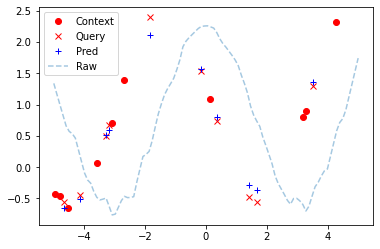

In [33]:
plt.plot(x_a[0], y_a[0], "ro", label="Context")
plt.plot(x_b[0], y_b[0], "rx", label="Query")
plt.plot(x_b[0], predictions, "+b", label="Pred")
plt.plot(np.linspace(-5, 5, 100), apply_fn(output["trained_params"], np.linspace(-5, 5, 100)[:, np.newaxis]), "--", label="Raw", alpha=0.4)
plt.legend()